In [14]:
# read in the roi file and separate channel for nuclei detection
# for each roi, get bounding box, apply threshold, should be one object: nucleus
# count spots in the nucleus and in the cytoplasm

# 3D spot finding
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from skimage import filters
import numpy as np

home_dir = "/Users/snk218/Dropbox (NYU Langone Health)/mac_files"
img_dir = "holtlab/data_and_results/Farida_LINE1/spot_counting/20221030_LINE1"


In [15]:
df_dox = pd.read_csv(f"{home_dir}/{img_dir}/dox/results/all_spots.txt", sep='\t')
df_dox['roi']=df_dox['roi'].fillna('')

df_nodox = pd.read_csv(f"{home_dir}/{img_dir}/no_dox/results/all_spots.txt", sep='\t')
df_nodox['roi']=df_nodox['roi'].fillna('')

In [16]:
def plot_intensity_kde(cur_df, nrows, ncols, size):
    fig,axs=plt.subplots(nrows, ncols, figsize=size)
    i=0; j=0
    for roi in cur_df.roi.unique():
        data = cur_df[cur_df.roi==roi]['nuclei_ch_intensity']
        
        if(len(data)>0):
            sns.histplot(x=data, ax=axs[i][j], #stat='probability', 
                         bins=np.linspace(data.min(),data.max(),30)) #,kde=True,)
            
            if(len(data)>1):
                kmeans = KMeans(n_clusters=2, random_state=0).fit(data.to_numpy().reshape(-1, 1))

                if(data[kmeans.labels_==0].max() < data[kmeans.labels_==1].min()):
                    th1 = (data[kmeans.labels_==0].max() + data[kmeans.labels_==1].min())/2
                else:
                    th1 = (data[kmeans.labels_==1].max() + data[kmeans.labels_==0].min())/2

                th2=filters.threshold_otsu(data)

                axs[i][j].axvline(th1, color='red')
                axs[i][j].axvline(th2, color='green')

        axs[i][j].set_title(f"{roi} ({len(data)})")
        
        if(j == (ncols-1)):
            i+=1; j=0
        else:
            j+=1
    plt.tight_layout()
    plt.show()
    
# Use cutoff to locate spots, plot intensity histograms of coloc-channel for each
def plot_intensity_kde_2(cur_df, nrows, ncols, size):
    fig,axs=plt.subplots(nrows, ncols, figsize=size)
    i=0; j=0
    for roi in cur_df.roi.unique():
        data = cur_df[cur_df.roi==roi]['nuclei_ch_intensity']
        
        if(len(data)>1):
            
            kmeans = KMeans(n_clusters=2, random_state=0).fit(data.to_numpy().reshape(-1, 1))

            if(data[kmeans.labels_==0].max() < data[kmeans.labels_==1].min()):
                th1 = (data[kmeans.labels_==0].max() + data[kmeans.labels_==1].min())/2
            else:
                th1 = (data[kmeans.labels_==1].max() + data[kmeans.labels_==0].min())/2

            th2=filters.threshold_otsu(data)
            
            final_th = np.mean([th1, th2])
            
            # plot nucl and cyto colocalization intensity
            nucl_data = cur_df[(cur_df.roi==roi) & (cur_df.nuclei_ch_intensity > final_th)]['coloc_ch_intensity']
            cyt_data = cur_df[(cur_df.roi==roi) & (cur_df.nuclei_ch_intensity <= final_th)]['coloc_ch_intensity']
            #min_=int(np.min(nucl_data.min(),cyt_data.min()))-1
            #max_=int(np.max(nucl_data.max(),cyt_data.max()))+1
            sns.kdeplot(x=nucl_data, ax=axs[i][j], label="nucl") #, stat='probability', kde=True)
                         #bins=np.linspace(min_,max_,30), label="nucl") #,kde=True,)
            sns.kdeplot(x=cyt_data, ax=axs[i][j], label="cyt") #, stat='probability', kde=True)
                         #bins=np.linspace(min_,max_,30), label="cyt") #,kde=True,)

        nucl_mean = round(np.mean(nucl_data))
        cyt_mean = round(np.mean(cyt_data))
        axs[i][j].set_title(f"{roi}\n(n={len(nucl_data)}/{len(cyt_data)} intens={nucl_mean}/{cyt_mean})")
        axs[i][j].legend()
        
        if(j == (ncols-1)):
            i+=1; j=0
        else:
            j+=1
    plt.tight_layout()
    plt.show()

def get_spot_counts(df):
    
    output_arr=[]
    for file_name in df.file_name.unique():

        cur_df=df[df.file_name==file_name]

        print(file_name)
        print(len(cur_df.roi.unique()))

        for roi in cur_df.roi.unique():
            data = cur_df[cur_df.roi==roi]['nuclei_ch_intensity']
            if(len(data)>1):
                kmeans = KMeans(n_clusters=2, random_state=0).fit(data.to_numpy().reshape(-1, 1))

                if(data[kmeans.labels_==0].max() < data[kmeans.labels_==1].min()):
                    th1 = (data[kmeans.labels_==0].max() + data[kmeans.labels_==1].min())/2
                else:
                    th1 = (data[kmeans.labels_==1].max() + data[kmeans.labels_==0].min())/2

                th2=filters.threshold_otsu(data)

                output_arr.append([file_name, roi, len(data), 
                                 th1, len(data[data>th1]), len(data[data<=th1]),
                                 th2, len(data[data>th2]), len(data[data<=th2])])
            else:
                output_arr.append([file_name, roi, len(data), 0, 0, 0, 0, 0, 0])

    return pd.DataFrame(output_arr, columns=["file_name","roi","num_spots",
                                                "th1 (kmeans)","num_nuclei_spots1","num_cyto_spots1",
                                                "th2 (otsu)","num_nuclei_spots2","num_cyto_spots2"])

In [17]:
output_df_dox = get_spot_counts(df_dox)
output_df_dox.to_csv(f"{home_dir}/{img_dir}/dox/results/roi_spot_counts.txt", sep='\t')

output_df_nodox = get_spot_counts(df_nodox)
#output_df_nodox.to_csv(f"{home_dir}/{img_dir}/no_dox/results/roi_spot_counts.txt", sep='\t')

zstack_004
5
zstack_005
10
zstack_001
6
zstack_002
5
zstack_003
5
zstack_nodox_006
5
zstack_nodox_007
5
zstack_nodox_008
4


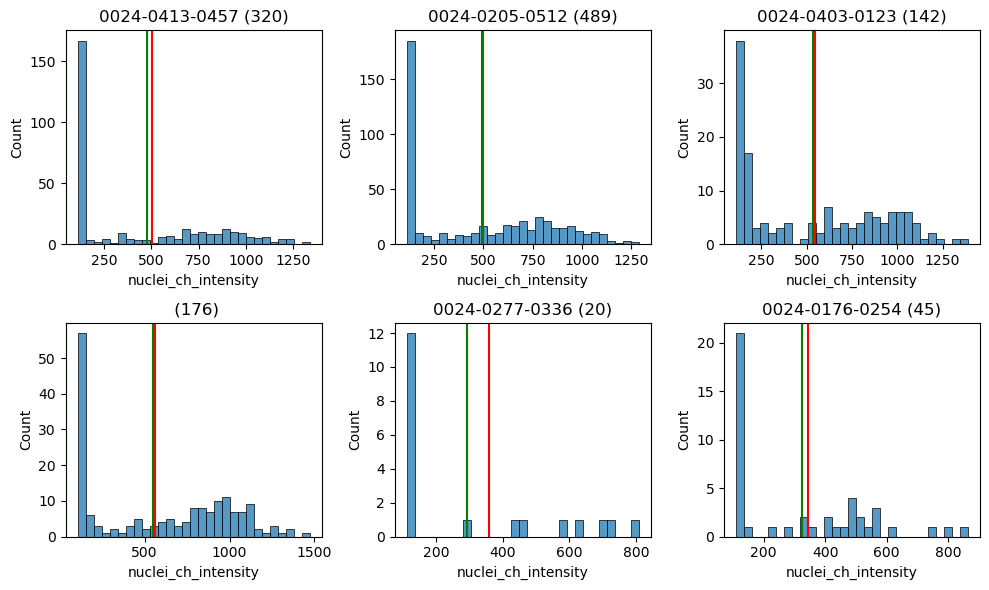

In [12]:
plot_intensity_kde(df_dox[df_dox.file_name=='zstack_001'], 2, 3, (10,6))

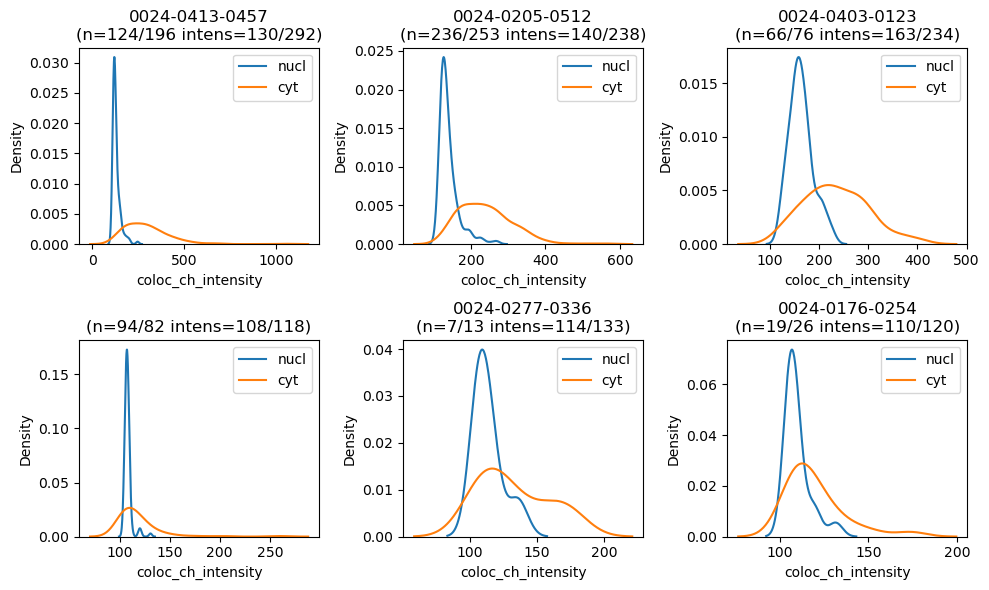

In [13]:
plot_intensity_kde_2(df_dox[df_dox.file_name=='zstack_001'], 2, 3, (10,6))

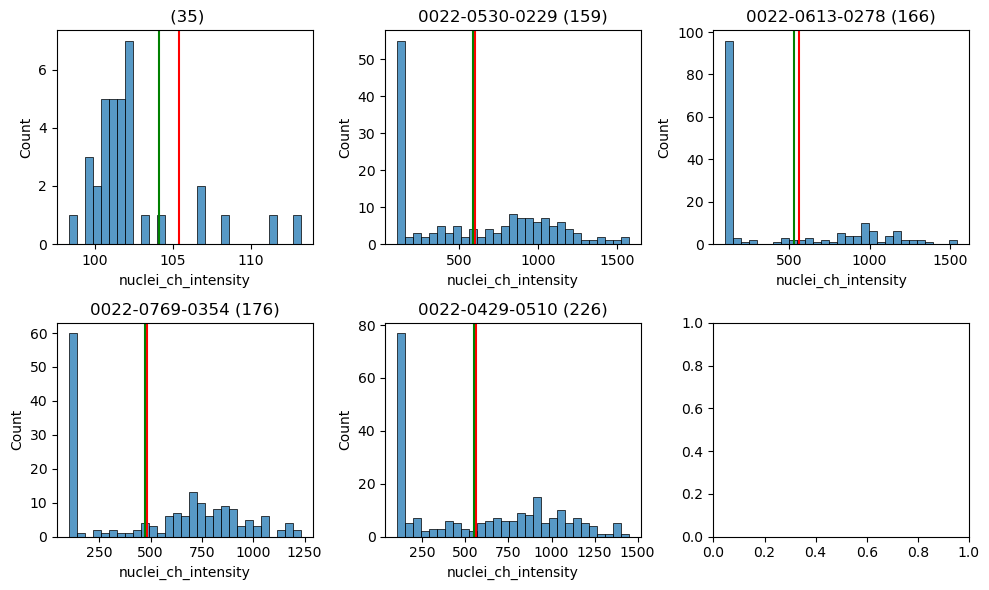

In [19]:
plot_intensity_kde(df_dox[df_dox.file_name=='zstack_002'], 2, 3, (10,6))

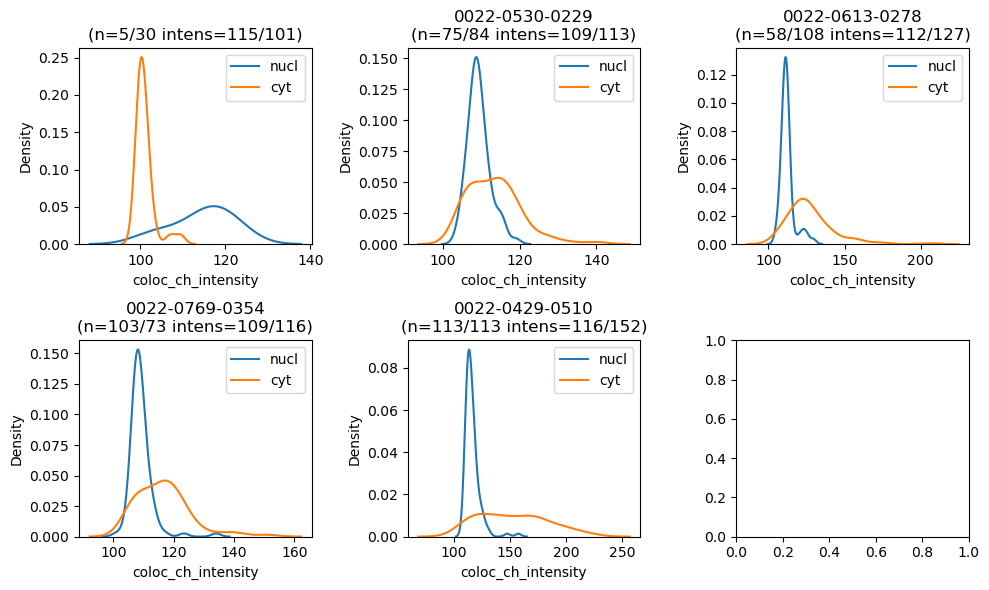

In [20]:
plot_intensity_kde_2(df_dox[df_dox.file_name=='zstack_002'], 2, 3, (10,6))

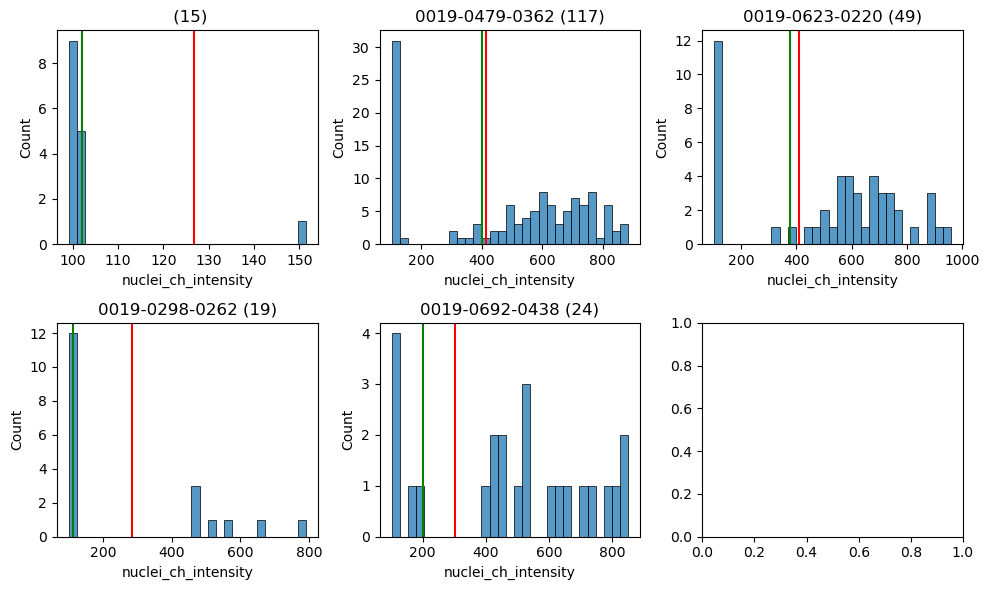

In [69]:
plot_intensity_kde(df_dox[df_dox.file_name=='zstack_003'], 2, 3, (10,6))

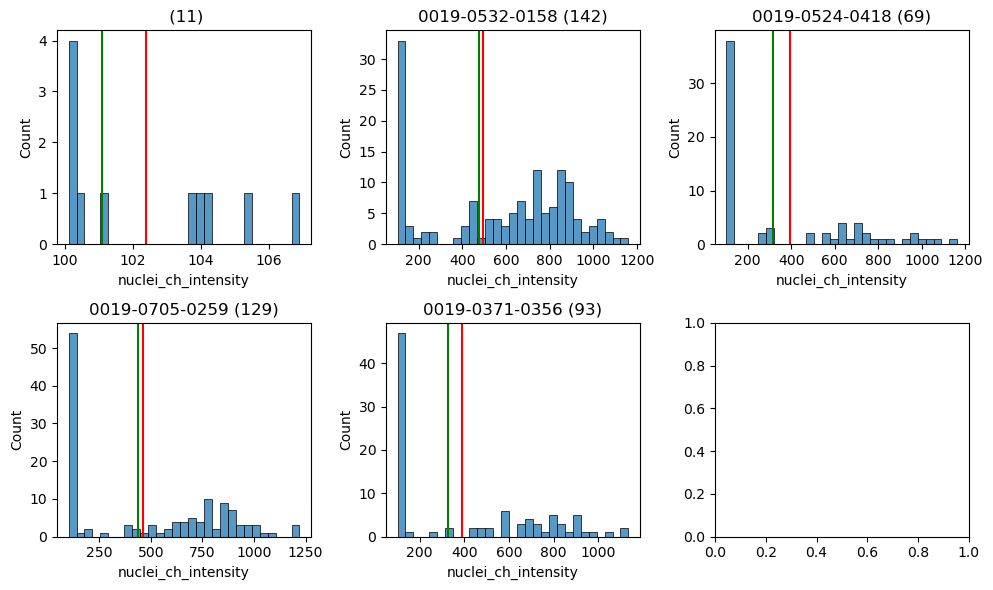

In [70]:
plot_intensity_kde(df_dox[df_dox.file_name=='zstack_004'], 2, 3, (10,6))

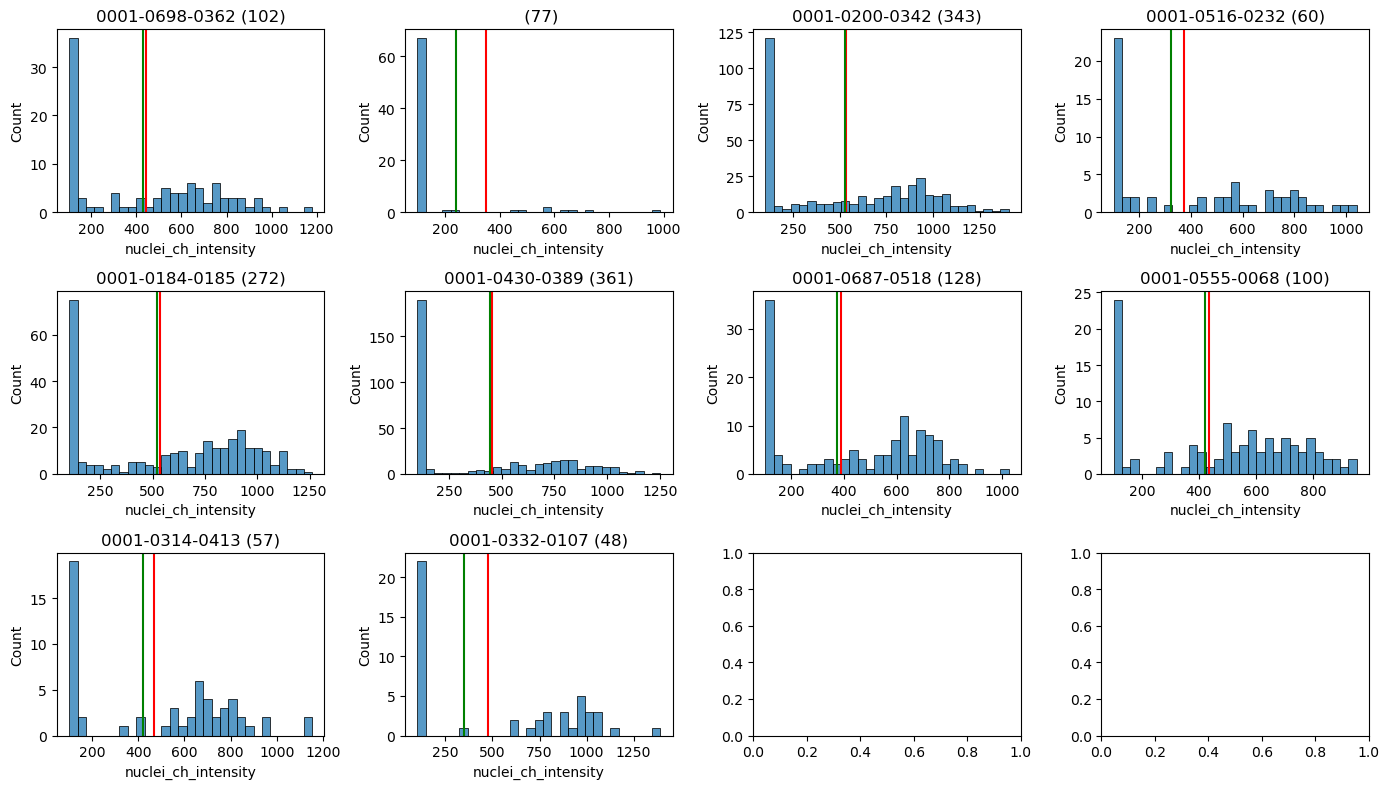

In [71]:
plot_intensity_kde(df_dox[df_dox.file_name=='zstack_005'], 3, 4, (14,8))

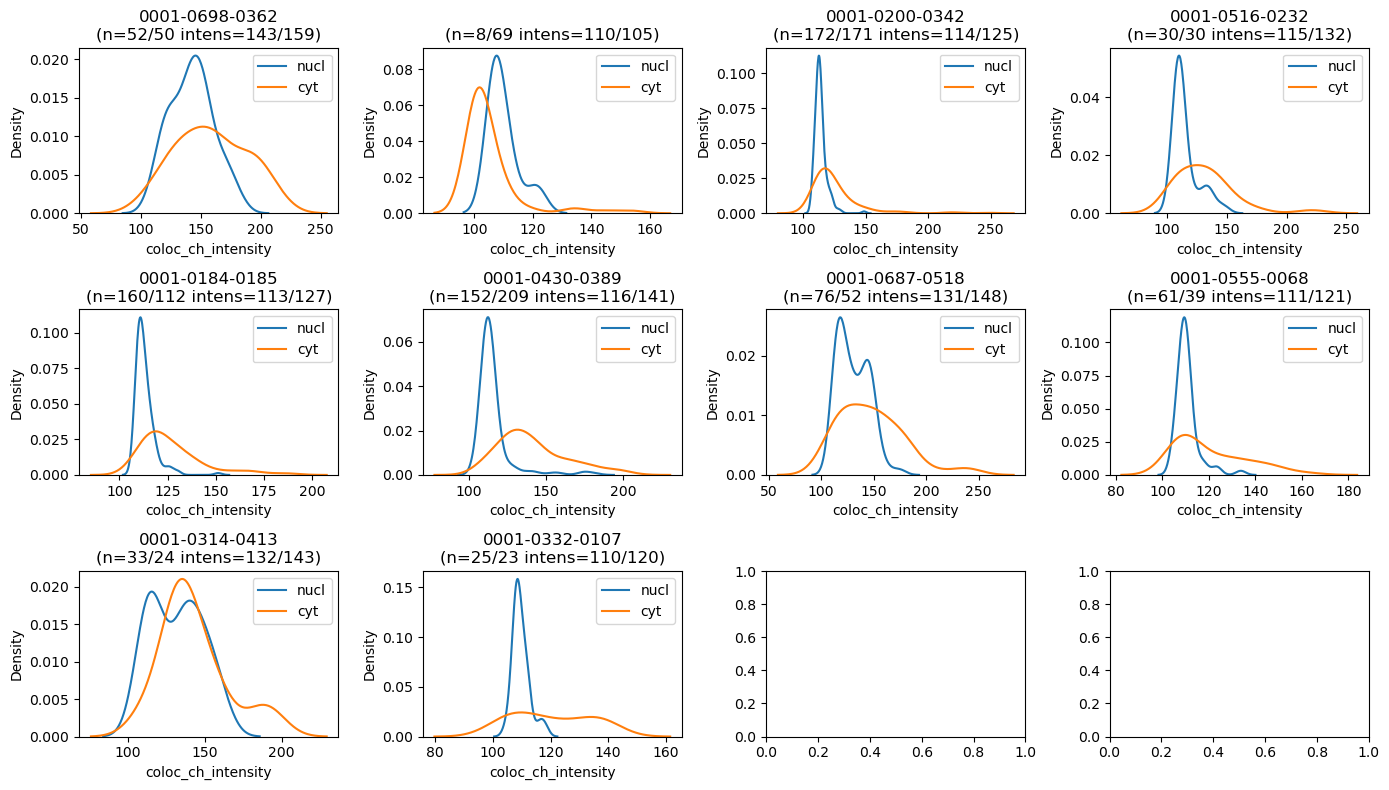

In [96]:
plot_intensity_kde_2(df_dox[df_dox.file_name=='zstack_005'], 3, 4, (14,8))

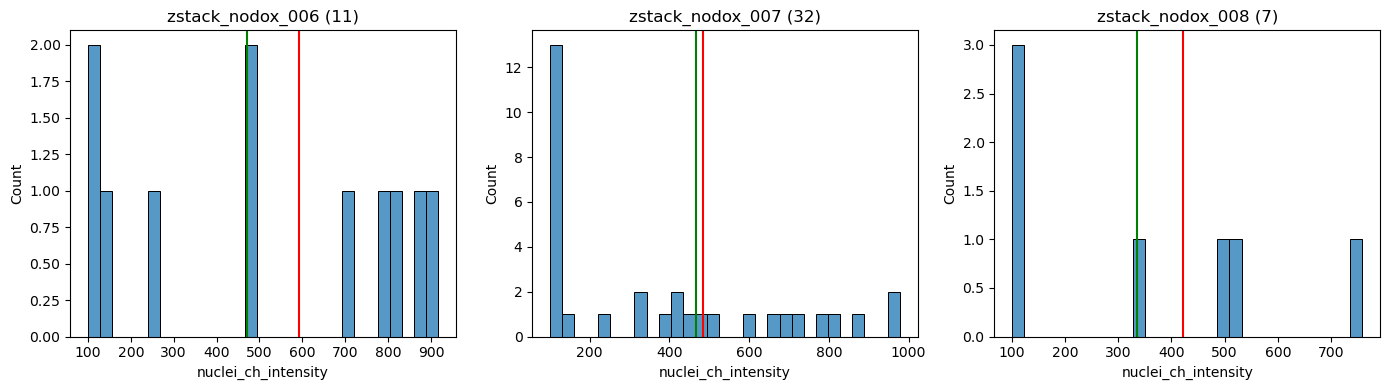

In [72]:
fig,axs=plt.subplots(1, 3, figsize=(14,4))
i=0
for file_name in df_nodox.file_name.unique():
    data = df_nodox[df_nodox.file_name==file_name]['nuclei_ch_intensity']


    sns.histplot(x=data, ax=axs[i], #stat='probability', 
                 bins=np.linspace(data.min(),data.max(),30)) #,kde=True,)


    kmeans = KMeans(n_clusters=2, random_state=0).fit(data.to_numpy().reshape(-1, 1))

    if(data[kmeans.labels_==0].max() < data[kmeans.labels_==1].min()):
        th1 = (data[kmeans.labels_==0].max() + data[kmeans.labels_==1].min())/2
    else:
        th1 = (data[kmeans.labels_==1].max() + data[kmeans.labels_==0].min())/2

    th2=filters.threshold_otsu(data)

    axs[i].axvline(th1, color='red')
    axs[i].axvline(th2, color='green')

    axs[i].set_title(f"{file_name} ({len(data)})")

    i+=1
        
plt.tight_layout()
plt.show()